In [1]:
from src.commons.utils import to_numpy, SegAnyChangeVersion, show_img, show_pair_img, show_prediction_sample
from src.models.commons.mask_process import extract_object_from_batch
import torch
from src.data.process import generate_grid_prompt
import numpy as np
from src.commons.utils import create_sample_grid_with_prompt, get_mask_with_prompt, fig2arr

import numpy as np
import cv2
from PIL import Image
import torch
import pytorch_lightning as pl
import pandas as pd
import os
from copy import deepcopy
import torch.nn.functional as F
from torchmetrics import Metric
from tqdm import tqdm
import torch
import matplotlib.pyplot as plt
from torch.utils import data
from torch.nn.utils.rnn import pad_sequence

In [2]:
from src.data.loader import BiTemporalDataset
from src.data.process import DefaultTransform
from omegaconf import OmegaConf

params = {
    "prompt_type": "sample",
    "n_prompt": 1,
    "loc": "center",
    "batch_size": 4,
}
ds = BiTemporalDataset(
            name="levir-cd",
            dtype="test",
            transform=DefaultTransform(),
            params=OmegaConf.create(params),
        )

In [3]:
from typing import List, Tuple, Dict, Any
def collate_align_prompt(input: List[Any]):

    prompt_pts = [d["point_coords"] for d in input]
    prompt_labels = [d["point_labels"] for d in input]

    # we set -1 as value to ignore prompt
    batch_pts = pad_sequence(prompt_pts, batch_first=True, padding_value=0)
    # negative prompt : 0 is ignore - (same as positive prompt btw)
    batch_labels = pad_sequence(prompt_labels, batch_first=True, padding_value=0)


    for i in range(len(input)):
        input[i]["point_coords"] = batch_pts[i]
        input[i]["point_labels"] = batch_labels[i]

    return data._utils.collate.default_collate(input)

In [4]:
dloader = data.DataLoader(
            ds,
            batch_size=params.get('batch_size'),
            shuffle=False,
            num_workers=0,
            collate_fn=collate_align_prompt
        )

In [5]:
batch = next(iter(dloader))

/home/MDizier/data/dl/levir-cd/test/label/test_1.png
FIND SHAPES 12
/home/MDizier/data/dl/levir-cd/test/label/test_2.png
FIND SHAPES 48
/home/MDizier/data/dl/levir-cd/test/label/test_3.png
FIND SHAPES 7
/home/MDizier/data/dl/levir-cd/test/label/test_4.png
FIND SHAPES 11


In [6]:
from src.commons.utils_io import load_sam
from src.models.commons.bisam import BiSam2, SamModeInference
from src.commons.utils import batch_to_list

In [7]:
bisam2 = load_sam(
    model_type="vit_b", model_cls=BiSam2, version= "dev2", device="cpu"
)

2024-07-17 19:17:44,076 - INFO ::  build vit_b BiSam2


In [8]:
out = bisam2(batch, multimask_output=False)

torch.Size([1, 1, 256, 256])
torch.Size([1, 1, 256, 256])
torch.Size([1, 1, 256, 256])
torch.Size([1, 1, 256, 256])


In [9]:
preds = bisam2.upscale_masks(out["masks"], (1024, 1024))

In [10]:
preds.shape

torch.Size([4, 1, 1, 1024, 1024])

In [11]:
preds = (preds > 0.).squeeze(1).squeeze(1)
preds.shape

torch.Size([4, 1024, 1024])

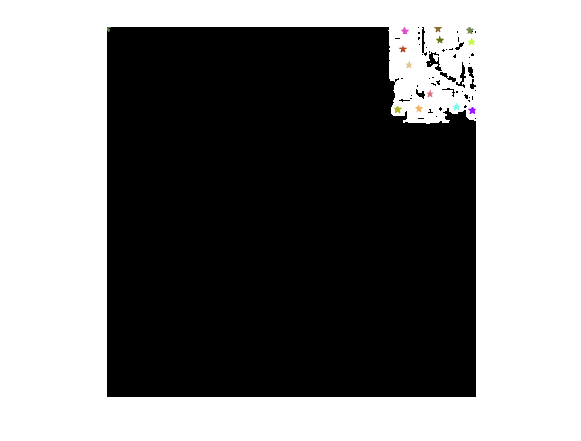

In [12]:
idx = 0
mask = to_numpy(preds[idx], transpose=False)
coord_points = batch["point_coords"][idx]
mask_pt = get_mask_with_prompt(mask, coord_points)
show_img(mask_pt)

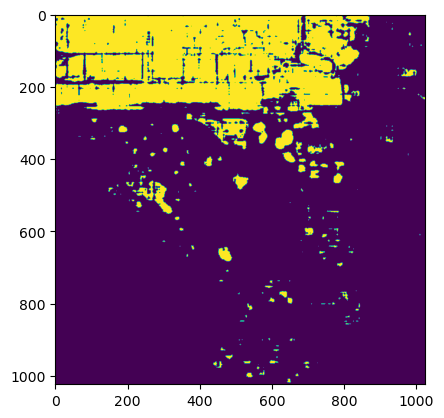

In [14]:
plt.imshow(to_numpy(preds[1], transpose=False))

In [13]:
preds[0].shape

torch.Size([1024, 1024])

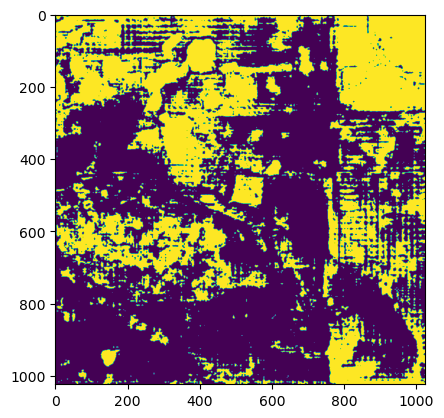

In [13]:
# we padding points
plt.imshow(to_numpy(preds[0], transpose=False))

In [17]:
from src.models.segment_anything import sam_model_registry_ori, SamPredictor
from src.commons.constants import SAM_MODEL_SMALL_PATH

idx= 0
img_path = f"/home/MDizier/data/dl/levir-cd/test/B/test_{idx+1}.png"

image = cv2.imread(img_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

device = "cuda"
model_type = "vit_b"

sam = sam_model_registry_ori[model_type](checkpoint=SAM_MODEL_SMALL_PATH)
sam.to(device=device)

predictor = SamPredictor(sam)
predictor.set_image(image)


2024-07-17 18:31:21,549 - INFO ::  build SAM


In [18]:
input_point = to_numpy(batch["point_coords"][idx], transpose=False)
input_label = to_numpy(batch["point_labels"][idx], transpose=False)

In [19]:
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=False,
)

sparse emb : torch.Size([1, 49, 256])
dense emb : torch.Size([1, 256, 64, 64])
low mask  predict torch : torch.Size([1, 1, 256, 256])
low mask  predict torch : torch.Size([1, 1, 1024, 1024])


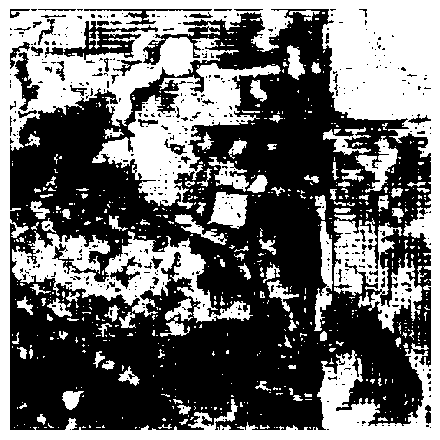

In [23]:
show_img(masks.squeeze())